In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import estimate_k_A, cdf, Weibull_PDF, weibull_parameters, sector_split, frequency_calculation, power_curve, pdf_sector, sorting_sector_values, aep_calculation, aep_calculation_2
from datetime import datetime
from scipy.special import gamma



# Extracting data from sprog.tsv

In [127]:
# Creating data headers for the DataFrame
headers_sprogo = ["timestamp", "wind_speed", "wind_direction_67.5", "wind_direction_70"]

# Reading the file into a DataFrame
df_sprogo = pd.read_csv("sprog.tsv", sep="\t", names=headers_sprogo)

# Turning the DataFrame into an array with object type values
array_sprogo = df_sprogo.to_numpy(dtype=object)

# Process each row to combine the third and fourth columns, keeping only valid values
processed_rows = []
for row in array_sprogo:
    # Check if the second column has the value 99.99
    if row[1] == 99.99:
        continue  # Skip rows where the second column has 99.99

    # Check the values in the third and fourth columns for 999.0 or 99.0
    if (row[2] in [999.0, 99.0, 99.99]) and row[3] not in [999.0, 99.0, 99.99]:
        row[2] = row[3]  # Replace 999.0 or 99.0 in the third column with the fourth column's value
    elif (row[3] in [999.0, 99.0, 99.99]) and row[2] not in [999.0, 99.0, 99.99]:
        row[3] = row[2]  # Replace 999.0 or 99.0 in the fourth column with the third column's value
    elif row[2] in [999.0, 99.0, 99.99] and row[3] in [999.0, 99.0, 99.99]:
        continue  # Skip rows where both values are 999.0 or 99.0

    # Append the processed row, keeping only the first three columns
    processed_rows.append([row[0], row[1], row[3]])

#print(processed_rows)

# Convert the list of processed rows back into a NumPy array
array_sprogo_processed = np.array(processed_rows, dtype=float)


# returns a np.array Nx3 (datetime, ws, wd)
angle_sectors= sector_split(array_sprogo_processed)


# AEP calculation

In [128]:
# Number of hours in a year
T = 24 * 365.25  # hours

## FREQUENCIES ##
# Calculate the total number of wind directions
total_directions = len(array_sprogo_processed)

# Calculate the frequency of occurrence in each sector and returns a 1x12 (1 for each of the 12 sectors)
frequencies= frequency_calculation(angle_sectors, array_sprogo_processed)



## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(angle_sectors)

## PDF ##
## PDF by Weibull parameters estimation 1 array per sector
k,A,pdf_sectors,k_weibull = pdf_sector(angle_sectors)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(angle_sectors, P_U_sectors, pdf_sectors)


# AEP CALCULATION
sectoral_AEP, total_AEP=aep_calculation(angle_sectors,frequencies , P_U_sorted, pdf_sorted, U_sorted, "for Sprogo at 70m")




############################# Calculating the AEP for k=0.85*k to simulate vertical extrapolation ###################

k,A,pdf_sectors,k_weibull = pdf_sector(angle_sectors, og_k=1)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(angle_sectors, P_U_sectors, pdf_sectors)


# AEP CALCULATION
sectoral_AEP_120, total_AEP_120=aep_calculation(angle_sectors,frequencies , P_U_sorted, pdf_sorted, U_sorted, "for Sprogo at 120m")



# Function to calculate percentage difference
def calculate_percentage_difference(list1, list2):
    percentage_differences = []
    for val1, val2 in zip(list1, list2):
        if val1 != 0:  # Avoid division by zero
            percentage_change = ((val2 - val1) / val1) * 100
        else:
            percentage_change = float('inf')  # Represent undefined change
        percentage_differences.append(percentage_change)
    return percentage_differences

# Calculate percentage differences
percentage_differences = calculate_percentage_difference(sectoral_AEP, sectoral_AEP_120)

# Print the results
for i, pct_diff in enumerate(percentage_differences):
    print(f"Percentage change between AEP_list[{i}] and AEP_list_2[{i}]: {pct_diff:.2f}%")


Annual Energy Production (AEP) for each sector for Sprogo at 70m: [1726.8859667033712, 1368.4643713678497, 1582.8791782414105, 3608.565198240065, 4986.545521798499, 2938.2675687497513, 4379.938498833469, 6525.64590047226, 6758.486987354646, 7016.549921869018, 4225.87578062705, 1793.328118678706]
Annual Energy Production (AEP): 46911.4330129361
Annual Energy Production (AEP) for each sector for Sprogo at 120m: [1773.022086977913, 1413.3940593005511, 1628.3395889938088, 3579.2251820991355, 4902.870276714279, 2967.088930670466, 4317.684583785601, 6391.043116811515, 6624.909759968848, 6846.291188224122, 4146.400351839094, 1851.4491652657148]
Annual Energy Production (AEP): 46441.71829065106
Percentage change between AEP_list[0] and AEP_list_2[0]: 2.67%
Percentage change between AEP_list[1] and AEP_list_2[1]: 3.28%
Percentage change between AEP_list[2] and AEP_list_2[2]: 2.87%
Percentage change between AEP_list[3] and AEP_list_2[3]: -0.81%
Percentage change between AEP_list[4] and AEP_list_

# 1 b

In [129]:
# separate the values for the original cleaned dataset
ts=[]
ws=[]
wd=[]
for i, row in enumerate(array_sprogo_processed):
    timest=row[0]
    wind_s=row[1]
    wind_d=row[2]

    ts.append(int(timest))
    ws.append(wind_s)
    wd.append(wind_d)



# Convert timestamps to datetime objects
ts_datetime = [datetime.strptime(str(int(t)), "%Y%m%d%H%M") for t in ts]

# Combine the columns into an n x 3 array
data = np.array([ts_datetime, ws, wd]).T

# Group data by custom year (September to September)
yearly_data = {}
for row in data:
    timestamp = row[0]  # First column is the timestamp (datetime object)
    year = timestamp.year
    # Adjust year for September to September grouping
    if timestamp.month < 9:
        year -= 1
    if year not in yearly_data:
        yearly_data[year] = []
    yearly_data[year].append(row)

# Convert grouped data to numpy arrays
yearly_arrays = {year: np.array(rows) for year, rows in yearly_data.items()}

# Print results for verification
for year, array in yearly_arrays.items():
    print(f"Data for custom year starting in September {year} to September {year + 1}:")
    #print(array)
    print(year)



Data for custom year starting in September 1977 to September 1978:
1977
Data for custom year starting in September 1978 to September 1979:
1978
Data for custom year starting in September 1979 to September 1980:
1979
Data for custom year starting in September 1980 to September 1981:
1980
Data for custom year starting in September 1981 to September 1982:
1981
Data for custom year starting in September 1982 to September 1983:
1982
Data for custom year starting in September 1983 to September 1984:
1983
Data for custom year starting in September 1984 to September 1985:
1984
Data for custom year starting in September 1985 to September 1986:
1985
Data for custom year starting in September 1986 to September 1987:
1986
Data for custom year starting in September 1987 to September 1988:
1987
Data for custom year starting in September 1988 to September 1989:
1988
Data for custom year starting in September 1989 to September 1990:
1989
Data for custom year starting in September 1990 to September 199

In [130]:

keys = yearly_arrays.keys()
#print(type(keys[0]))
mean_values=[]
for key in keys:
    values=yearly_arrays[key]
    ws=[]
    for i in range(len(values)):
        ws.append(values[i][1])
    mean_ws=np.mean(ws)
    #print(len(ws))
    mean_values.append([key,mean_ws])
print(mean_values)

last_value = mean_values.pop()

# Find the maximum and minimum based on the second value
max_entry = max(mean_values, key=lambda x: x[1])  # Finds the entry with the max second value
min_entry = min(mean_values, key=lambda x: x[1])  # Finds the entry with the min second value

# Print the results
print(f"Maximum value: {max_entry[1]} in year {max_entry[0]}")
print(f"Minimum value: {min_entry[1]} in year {min_entry[0]}")



#print(type(max_entry[0])) 
year_of_max_mean_ws= yearly_arrays[max_entry[0]]
year_of_min_mean_ws= yearly_arrays[min_entry[0]]
# year_of_max_mean_ws= yearly_arrays[1980]
# year_of_min_mean_ws= yearly_arrays[1988]

print(year_of_max_mean_ws)
print(year_of_min_mean_ws)
#print(year_of_max_mean_ws)

[[1977, 8.15764868548403], [1978, 8.607227975790183], [1979, 8.20404704288065], [1980, 8.897557897267411], [1981, 7.530356721392932], [1982, 8.346557666556699], [1983, 8.515616060034667], [1984, 8.0125196474897], [1985, 8.100405980053775], [1986, 8.2340262861721], [1987, 8.671026145696652], [1988, 8.235175403225808], [1989, 8.138184138837559], [1990, 7.814191789180634], [1991, 8.286537063469408], [1992, 8.324408754919842], [1993, 8.27375461837395], [1994, 8.833879464715508], [1995, 7.56298338209703], [1996, 7.858415132533802], [1997, 8.45272398155558], [1998, 8.022217767340626], [1999, 5.719780952380953]]
Maximum value: 8.897557897267411 in year 1980
Minimum value: 7.530356721392932 in year 1981
[[datetime.datetime(1980, 9, 1, 0, 5) 6.07 43.0]
 [datetime.datetime(1980, 9, 1, 0, 15) 5.87 45.0]
 [datetime.datetime(1980, 9, 1, 0, 25) 5.72 42.0]
 ...
 [datetime.datetime(1981, 8, 31, 23, 35) 6.01 20.0]
 [datetime.datetime(1981, 8, 31, 23, 45) 6.04 23.0]
 [datetime.datetime(1981, 8, 31, 23, 

# AEP calculation for extreme years

In [131]:
# returns a np.array Nx3 (datetime, ws, wd)
angle_sectors= sector_split(year_of_max_mean_ws)

## FREQUENCIES ##
# Calculate the total number of wind directions
total_directions = len(year_of_max_mean_ws)

# Calculate the frequency of occurrence in each sector and returns a 1x12 (1 for each of the 12 sectors)
frequencies= frequency_calculation(angle_sectors, year_of_max_mean_ws)

## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(angle_sectors)

## PDF ##
## PDF by Weibull parameters estimation 1 array per sector
k,A,pdf_sectors,k_weibull = pdf_sector(angle_sectors, og_k=1)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(angle_sectors, P_U_sectors, pdf_sectors)


# AEP CALCULATION
sectoral_AEP, total_AEP=aep_calculation(angle_sectors,frequencies , P_U_sorted, pdf_sorted, U_sorted, "for sprogo at 120m for year with max mean ws")



################################################### Doing the same for the year of min wind speed ########################################

# returns a np.array Nx3 (datetime, ws, wd)
angle_sectors= sector_split(year_of_min_mean_ws)

## FREQUENCIES ##
# Calculate the total number of wind directions
total_directions = len(year_of_min_mean_ws)

# Calculate the frequency of occurrence in each sector and returns a 1x12 (1 for each of the 12 sectors)
frequencies= frequency_calculation(angle_sectors, year_of_min_mean_ws)

## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(angle_sectors)

## PDF ##
## PDF by Weibull parameters estimation 1 array per sector
k,A,pdf_sectors,k_weibull = pdf_sector(angle_sectors,og_k=1)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(angle_sectors, P_U_sectors, pdf_sectors)


# AEP CALCULATION
sectoral_AEP, total_AEP=aep_calculation(angle_sectors,frequencies , P_U_sorted, pdf_sorted, U_sorted, "for sprogo at 120m for year with min mean ws")

    

Annual Energy Production (AEP) for each sector for sprogo at 120m for year with max mean ws: [2084.083645574659, 1727.1652092882284, 1359.4756543280903, 3164.485826799924, 4465.564000336787, 1764.8797918436815, 2523.394387335254, 7178.932619031004, 9650.624320987936, 8935.862831445795, 4986.276460058106, 2997.7331205356522]
Annual Energy Production (AEP): 50838.477867565125
Annual Energy Production (AEP) for each sector for sprogo at 120m for year with min mean ws: [1783.7881369528006, 607.2404069872149, 468.48646950093803, 2322.580679067426, 4762.139384935216, 3362.9343711817164, 4388.873897364283, 5215.528487081176, 5175.045080595757, 6352.046506969724, 4171.690325958214, 1831.820739943535]
Annual Energy Production (AEP): 40442.174486538


# Horizontal extrapolation for Nyborg Korsor

In [132]:
# U star computation using log-law

u_mean_values=[]
for row in array_sprogo_processed:
    u_mean_values.append(row[1])
u_mean=np.mean(u_mean_values)
z_measurement = 70
# u_mean = np.mean(sprogo.Windspeed)
vonKarman = 0.4
z_0_water = 0.0002
z_0_land = 0.03
z_hub = 112


u_star_sprog = u_mean*vonKarman/(np.log(z_measurement/z_0_water))

# Obtaining coriolis parameter from latitude

rot_earth = 7.2921e-5
latitude = 55.3

coriolis_parameter = 2*rot_earth*np.sin(latitude*np.pi/180)

# U-components using A and B from Mark's notes

A = 1.8
B = 4.5

u_g_sprog = u_star_sprog / vonKarman *(np.log((u_star_sprog / coriolis_parameter) / z_0_water) - A)

v_g_sprog = - B * u_star_sprog / vonKarman

G_sprog = np.sqrt(u_g_sprog**2 + v_g_sprog**2)


def gdl(mean_u, z_0, apply_increment=False):
    """
    Compute mean wind speed at hub height and friction velocity (u_star),
    optionally applying an increment to G based on mean_u.
    """
    # Compute u_star
    u_star = mean_u * vonKarman / (np.log(z_measurement / z_0_water))
    
    # Compute geostrophic wind components
    u_g = u_star / vonKarman * (np.log((u_star / coriolis_parameter) / z_0_water) - A)
    v_g = - B * u_star / vonKarman
    G = np.sqrt(u_g**2 + v_g**2)
    
    # Apply geostrophic increment to G if required
    if apply_increment:
        if mean_u >= 15 and mean_u <= 25:  # Increment applies only within this range
            delta_geo = (mean_u - 15) / (25 - 15) * 0.1  # Linear increase from 0% to 10%
            G *= (1 + delta_geo)  # Adjust G based on the increment
    
    # Iterative solution for u_star
    u_star_guess = 0.0001
    error = 1
    
    while error > 0.001:
        error = G - u_star_guess / vonKarman * np.sqrt(
            (np.log(u_star_guess / (coriolis_parameter * z_0)) - A) ** 2 + B ** 2
        )
        u_star_guess += 0.0001

    # Compute mean wind speed at hub height
    mean_u_new = u_star_guess / vonKarman * np.log(z_hub / z_0)
     
    return mean_u_new, u_star_guess


    
 # Obtaining windspeed at each sector for each location
 
roughness_nyborg = np.zeros((12,1))
 
roughness_korsor = np.zeros((12,1))


# create roughnes length profile based on wether ther is land or water in each sector
direction_sectors=np.arange(0,390,30)
roughness_nyborg[direction_sectors[0:12] <= 180] = z_0_water
roughness_nyborg[direction_sectors[0:12] > 180] = z_0_land

roughness_korsor[direction_sectors[0:12] > 180] = z_0_water
roughness_korsor[direction_sectors[0:12] <= 180] = z_0_land

u_nyborg = np.zeros((12,1))
u_korsor = np.zeros((12,1))
u_star_nyborg = np.zeros((12,1))
u_star_korsor = np.zeros((12,1))


angle_sectors= sector_split(array_sprogo_processed)


u_mean_sectors=[]
for j in range(12):
    mean_sector = []
    for row in angle_sectors[j]:
        mean_sector.append(row[1])
    u_mean=np.mean(mean_sector)
    u_mean_sectors.append(u_mean)

# print(u_mean_sectors)
# print(roughness_korsor)


nyborg_angle_sectors = [[] for _ in range(12)]
korsor_angle_sectors = [[] for _ in range(12)]

for i in range(12):

    u_nyborg[i], u_star_nyborg[i] = gdl(u_mean_sectors[i], roughness_nyborg[i])
    
    u_korsor[i], u_star_korsor[i] = gdl(u_mean_sectors[i], roughness_korsor[i])

# print(u_korsor)
# print(u_star_korsor)
    


# AEP for each location


A_weibull_nyborg = np.zeros((12,1))
A_weibull_korsor = np.zeros((12,1))

k,A,pdf_sectors,k_weibull = pdf_sector(angle_sectors)

# print(k_weibull)

for i in range(12):
    
    A_weibull_nyborg[i] = u_nyborg[i] / (gamma(1 + 1 / k_weibull[i]))
    A_weibull_korsor[i] = u_korsor[i] / (gamma(1 + 1 / k_weibull[i]))


T = 8760

weibull_nyborg = np.zeros((12,100))
weibull_korsor = np.zeros((12,100))

U = np.linspace(1,30,100)

for i in range(12):
    
    weibull_nyborg[i] = k_weibull[i]/U * (U/A_weibull_nyborg[i])**k_weibull[i] * np.exp(-(U/A_weibull_nyborg[i])**k_weibull[i])
    weibull_korsor[i] = k_weibull[i]/U * (U/A_weibull_korsor[i])**k_weibull[i] * np.exp(-(U/A_weibull_korsor[i])**k_weibull[i])
    

    #print(weibull_nyborg[i])
    nyborg_angle_sectors_ = []
    korsor_angle_sectors_ = []

    for u in range(len(weibull_nyborg[i])):

        nyborg_angle_sectors_.append([i, U[u], direction_sectors[i]])

        nyborg_angle_sectors[i] = np.array(nyborg_angle_sectors_)

        korsor_angle_sectors_.append([i, U[u], direction_sectors[i]])

        korsor_angle_sectors[i] = np.array(korsor_angle_sectors_)

print("here")
# print(len(nyborg_angle_sectors[0]))
# print(len(nyborg_angle_sectors[0][0]))
# print(angle_sectors)

#print(year_of_min_mean_ws)


################################################### Doing the same for the extrapolated sites - Nyborg ########################################

## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(nyborg_angle_sectors)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(nyborg_angle_sectors, P_U_sectors, pdf_sectors)


# AEP CALCULATION
# sectoral_AEP, total_AEP=aep_calculation(nyborg_angle_sectors, frequencies , P_U_sorted, pdf_sorted, U_sorted, "for sprogo at 70m for year with min mean ws")
sectoral_AEP, total_AEP=aep_calculation(nyborg_angle_sectors, frequencies , P_U_sorted, weibull_nyborg, U_sorted, "for Nyborg at 112m for year with min mean ws")



################################################### Doing the same for the extrapolated sites - Korsor ########################################

## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(korsor_angle_sectors)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(korsor_angle_sectors, P_U_sectors, pdf_sectors)

# print(weibull_korsor)
# print(U_sorted)



# AEP CALCULATION
# sectoral_AEP, total_AEP=aep_calculation(nyborg_angle_sectors, frequencies , P_U_sorted, pdf_sorted, U_sorted, "for sprogo at 70m for year with min mean ws")
sectoral_AEP, total_AEP=aep_calculation(korsor_angle_sectors, frequencies , P_U_sorted, weibull_korsor, U_sorted, "for Korsor at 112m for year with min mean ws")



here
Annual Energy Production (AEP) for each sector for Nyborg at 112m for year with min mean ws: [2232.658057411903, 1504.652915039324, 1192.4073903754768, 3296.6231909394105, 5937.638162112986, 3673.572977892769, 5000.450775366392, 4486.0426668540085, 4856.14533739985, 5758.914822009547, 3775.2796916272587, 1787.1420303923362]
Annual Energy Production (AEP): 43501.52801742126
Annual Energy Production (AEP) for each sector for Korsor at 112m for year with min mean ws: [1698.3728711469594, 1124.2308478349196, 882.7933157128831, 2510.886549098292, 4553.483929201386, 2810.1210333249514, 3919.424646118835, 5729.248752390854, 6150.429301924273, 7219.112385459044, 4752.559700590374, 2312.6606185995706]
Annual Energy Production (AEP): 43663.323951402344


# GDL correction error

In [133]:
z_hub = 112
u_korsor_correction = np.zeros((12,1))
u_korsor = np.zeros((12,1))
u_star_korsor_correction = np.zeros((12,1))
u_star_korsor = np.zeros((12,1))


angle_sectors= sector_split(array_sprogo_processed)


u_mean_sectors=[]
for j in range(12):
    mean_sector = []
    for row in angle_sectors[j]:
        mean_sector.append(row[1])
    u_mean=np.mean(mean_sector)
    u_mean_sectors.append(u_mean)

# print(u_mean_sectors)
# print(roughness_korsor)

korsor_correction_angle_sectors = [[] for _ in range(12)]
korsor_angle_sectors = [[] for _ in range(12)]

A = 1.8
B = 4.5

for i in range(12):

    u_korsor_correction[i], u_star_korsor_correction[i] = gdl(u_mean_sectors[i], roughness_nyborg[i], apply_increment=True)
    
    u_korsor[i], u_star_korsor[i] = gdl(u_mean_sectors[i], roughness_korsor[i], apply_increment=False)

# print(u_korsor)
# print(u_star_korsor)


# AEP for each location


A_weibull_korsor_correction = np.zeros((12,1))
A_weibull_korsor = np.zeros((12,1))

k,A,pdf_sectors,k_weibull = pdf_sector(angle_sectors)

# print(k_weibull)

for i in range(12):
    
    A_weibull_korsor_correction[i] = u_korsor_correction[i] / (gamma(1 + 1 / k_weibull[i]))
    A_weibull_korsor[i] = u_korsor[i] / (gamma(1 + 1 / k_weibull[i]))


T = 8760

weibull_korsor_correction = np.zeros((12,100))
weibull_korsor = np.zeros((12,100))

U = np.linspace(1,30,100)

for i in range(12):
    
    weibull_korsor_correction[i] = k_weibull[i]/U * (U/A_weibull_korsor_correction[i])**k_weibull[i] * np.exp(-(U/A_weibull_korsor_correction[i])**k_weibull[i])
    weibull_korsor[i] = k_weibull[i]/U * (U/A_weibull_korsor[i])**k_weibull[i] * np.exp(-(U/A_weibull_korsor[i])**k_weibull[i])

    #print(weibull_nyborg[i])
    korsor_correction_angle_sectors_ = []
    korsor_angle_sectors_ = []

    for u in range(len(weibull_korsor_correction[i])):

        korsor_correction_angle_sectors_.append([i, U[u], direction_sectors[i]])

        korsor_correction_angle_sectors[i] = np.array(korsor_correction_angle_sectors_)

        korsor_angle_sectors_.append([i, U[u], direction_sectors[i]])

        korsor_angle_sectors[i] = np.array(korsor_angle_sectors_)

print("here")
# print(nyborg_angle_sectors)
# print(len(nyborg_angle_sectors[0]))
# print(len(nyborg_angle_sectors[0][0]))
# print(angle_sectors)

#print(year_of_min_mean_ws)


################################################### Doing the same for the extrapolated sites - Nyborg ########################################

## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(korsor_correction_angle_sectors)


# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(korsor_correction_angle_sectors, P_U_sectors, pdf_sectors)


# AEP CALCULATION
# sectoral_AEP, total_AEP=aep_calculation(nyborg_angle_sectors, frequencies , P_U_sorted, pdf_sorted, U_sorted, "for sprogo at 70m for year with min mean ws")
sectoral_AEP_corrected, total_AEP_corrected=aep_calculation(korsor_correction_angle_sectors, frequencies , P_U_sectors, weibull_korsor_correction, U_sorted, "for Korsor at 120m with the new wind correction")


################################################### Doing the same for the extrapolated sites - Korsor ########################################

## POWER CURVE ##

# Calculate the power for each ws in each sector seperately (len=12)
P_U_sectors= power_curve(korsor_angle_sectors)



# sorting the u, p, pdf values from lower to higher (each of them is a Nx12 array)
U_sorted,P_U_sorted, pdf_sorted = sorting_sector_values(korsor_angle_sectors, P_U_sorted, pdf_sectors)



# AEP CALCULATION
# sectoral_AEP, total_AEP=aep_calculation(nyborg_angle_sectors, frequencies , P_U_sorted, pdf_sorted, U_sorted, "for sprogo at 70m for year with min mean ws")
sectoral_AEP, total_AEP=aep_calculation(korsor_angle_sectors, frequencies , P_U_sorted, weibull_korsor, U_sorted, "for Korsor at 120m")



# Difference calculation

correction_error = abs(total_AEP-total_AEP_corrected)/total_AEP_corrected*100
print("Relative error between both AEP fpor Korsor:", correction_error, "%")

here
Annual Energy Production (AEP) for each sector for Korsor at 120m with the new wind correction: [2232.658057411903, 1504.652915039324, 1192.4073903754768, 3296.6231909394105, 5937.638162112986, 3673.572977892769, 5000.450775366392, 4486.0426668540085, 4856.14533739985, 5758.914822009547, 3775.2796916272587, 1787.1420303923362]
Annual Energy Production (AEP): 43501.52801742126
Annual Energy Production (AEP) for each sector for Korsor at 120m: [1698.3728711469594, 1124.2308478349196, 882.7933157128831, 2510.886549098292, 4553.483929201386, 2810.1210333249514, 3919.424646118835, 5729.248752390854, 6150.429301924273, 7219.112385459044, 4752.559700590374, 2312.6606185995706]
Annual Energy Production (AEP): 43663.323951402344
Relative error between both AEP fpor Korsor: 0.3719316110374075 %


# Part 2

# Gumbel

[22.55, 22.76, 23.2, 23.46, 23.85, 24.16, 24.78, 25.28, 25.79, 26.19, 26.37, 26.65, 26.65, 26.68, 26.73, 26.75, 26.76, 27.93, 28.09, 28.79, 30.19, 32.97]


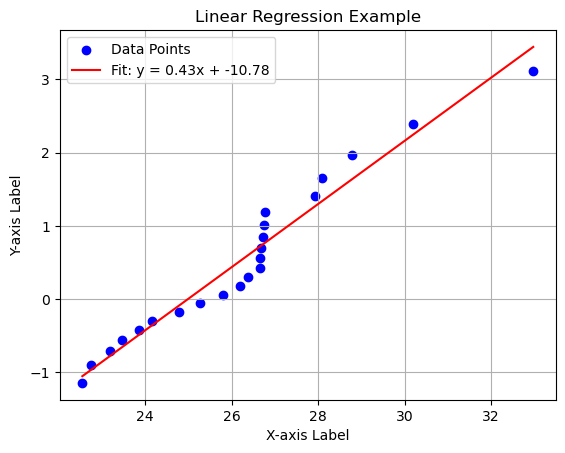

Linear Regression Results:
Slope: 0.4313422280382423
Intercept: -10.77791626969425
R-squared: 0.9575881030264088
P-value: 3.3838870020167813e-15
Standard Error: 0.020298383687000567
the U50 for Gumbel is: 34.056343942796175 m/s


In [134]:
keys = yearly_arrays.keys()
#print(type(keys[0]))
max_values=[]
for key in keys:
    values=yearly_arrays[key]
    ws=[]
    for i in range(len(values)):
        ws.append(values[i][1])
    max_ws=np.max(ws)
    #print(len(ws))
    max_values.append(max_ws)


last_value = max_values.pop()
sorted_max=  sorted(max_values)
print(sorted_max)

# creating a cumulative distribution function for each Xi (eaach years maxima)

F=[]
y_axis=[]
for i in range(1,len(sorted_max)+1):
    F.append(i/(len(sorted_max)+1))
    y_axis.append(-np.log(-np.log(F[i-1])))




from scipy.stats import linregress

# Example data
x = sorted_max  # X values
y = y_axis  # Y values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create the regression line
x_reg = np.linspace(min(x), max(x), 100)  # Generate x values for the line
y_reg = slope * x_reg + intercept         # Calculate corresponding y values

# Plot data points
plt.scatter(x, y, color='blue', label='Data Points')

# Plot regression line
plt.plot(x_reg, y_reg, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

# Add labels, title, and legend
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Linear Regression Example')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

# Print regression details
print("Linear Regression Results:")
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

alpha= 1/slope
beta=-alpha*intercept

U_50= alpha*np.log(50)+ beta
print(f"the U50 for Gumbel is: {U_50} m/s")


# PWM

In [141]:
euler_constant= 0.57721
N=len(sorted_max)
b_0= np.sum(sorted_max)/N
factor=[]
for i in range(1, len(sorted_max)+1):
    factor.append((i-1)*sorted_max[i-1])

factor_sum=np.sum(factor)

b_1= factor_sum/(N*(N-1))
print(b_1)
print(2*b_1-b_0)
alpha = (2*b_1-b_0)/np.log(2)
beta= b_0 -euler_constant*alpha

print(f"alpha = {alpha}")
print(f"beta = {beta}")
U_50= alpha*np.log(50)+ beta
print(f"the U50 for PWM is: {U_50} m/s")

13.796839826839827
1.3854978354978336
alpha = 1.9988508564351173
beta = 25.05442511533891
the U50 for PWM is: 32.87397565013284 m/s


# Weibull 

In [136]:
ws=[]
for i, row in enumerate(array_sprogo_processed):
    wind_s=row[1]
    ws.append(wind_s)
# c_ie=0.438*len(sorted_max)
c_ie=0.438*22

# Example data
m1 = np.mean(ws)  # Mean (first non-central moment)
sprogo_ws=np.array(ws)
m3 = np.nanmean(sprogo_ws**3)  # Third non-central moment
CDF_mean = cdf(ws, 'for Sprogo', np.mean(ws)  , 1)  # CDF at mean 


# Estimate k and A
k, A = estimate_k_A(m1, m3, CDF_mean)


print(f"k= {k}")
print(f"A= {A}")
beta= A*(np.log(c_ie))**(1/k)
alpha= A/k*(np.log(c_ie))**(1/(k-1))

print(f"alpha = {alpha}")
print(f"beta = {beta}")
U_50= alpha*np.log(50)+ beta
print(f"the U50 for Weibull is: {U_50} m/s")


k= 2.3316826494164746
A= 9.385972723415792
alpha = 7.438989652183678
beta = 13.329096638757548
the U50 for Weibull is: 42.430595295242014 m/s


# Horizontal extrapolation from sprogo to the other 2 sites

In [146]:
keys = yearly_arrays.keys()
#print(type(keys[0]))
max_values=[]
for key in keys:
    values=yearly_arrays[key]
    ws=[]
    for i in range(len(values)):
        ws.append(values[i][1])
    ws_sorted=np.sort(ws)

    #print(len(ws))
    max_values.append(ws_sorted[-1])

last_value = max_values.pop()
# print(max_values)


keys = yearly_arrays.keys()
top_5_values = {}


highest_ws_5 = []
highest_wd_5 = []

for key in keys:
    values = yearly_arrays[key]
    ws = []
    wd = []
    for i in range(len(values)):
        ws.append(values[i][1])  # Extract windspeed
        wd.append(values[i][2])  # Extract wind direction

    # Convert ws and wd into numpy arrays for indexing
    ws = np.array(ws)
    wd = np.array(wd)

    # Get the indices of the 5 highest wind speeds
    top_5_indices = np.argsort(ws)[-5:]  # Indices of the 5 largest values in ascending order

    # Retrieve the 5 highest wind speeds and corresponding wind directions
    top_5_ws = ws[top_5_indices]
    top_5_wd = wd[top_5_indices]

    # Sort the results in descending order of wind speed for clarity
    sorted_indices = np.argsort(top_5_ws)[::-1]
    top_5_ws = top_5_ws[sorted_indices]
    top_5_wd = top_5_wd[sorted_indices]

    highest_ws_5.append(top_5_ws)
    highest_wd_5.append(top_5_wd)

# Print the results
for i, key in enumerate(keys):
    print(f"Year: {key}")
    print(f"Top 5 Windspeeds: {highest_ws_5[i]}")
    print(f"Corresponding Directions: {highest_wd_5[i]}")
print(len(highest_ws_5))
print(type(highest_ws_5))
last_value = highest_wd_5.pop()
last_value = highest_ws_5.pop()







nyborg_angle_sectors = [[] for _ in range(len(highest_ws_5[0]))]
korsor_angle_sectors = [[] for _ in range(len(highest_ws_5[0]))]

A = 1.8
B = 4.5
print(len(highest_ws_5))

max_u_korsor_list=[]
max_wd_korsor_list=[]
max_u_nyborg_list=[]
max_wd_nyborg_list=[]
for i in range(len(highest_ws_5)):

    u_nyborg= [[] for _ in range(len(highest_ws_5[0]))]
    u_star_nyborg= [[] for _ in range(len(highest_ws_5[0]))]
    u_korsor= [[] for _ in range(len(highest_ws_5[0]))]
    u_star_korsor= [[] for _ in range(len(highest_ws_5[0]))]


    for v in range(len(highest_ws_5[0])):

        if highest_wd_5[i][v] <=180:
            u_nyborg[v], u_star_nyborg[v] = gdl(highest_ws_5[i][v], z_0_water, apply_increment=False)
        
            u_korsor[v], u_star_korsor[v] = gdl(highest_ws_5[i][v], z_0_land, apply_increment=False)
        if highest_wd_5[i][v] >180:
            u_nyborg[v], u_star_nyborg[v] = gdl(highest_ws_5[i][v], z_0_land, apply_increment=False)
        
            u_korsor[v], u_star_korsor[v] = gdl(highest_ws_5[i][v], z_0_water, apply_increment=False)
    

    max_u_korsor_list.append(np.max(u_korsor))
    max_u_korsor_index = np.argmax(u_korsor)
    max_wd_korsor_list.append(highest_wd_5[i][max_u_korsor_index])




    max_u_nyborg_list.append(np.max(u_nyborg))


print(max_u_korsor_list)
print(max_u_nyborg_list)
print(max_wd_korsor_list)



    


Year: 1977
Top 5 Windspeeds: [28.09 27.08 27.02 26.73 26.65]
Corresponding Directions: [271. 266. 269. 255. 262.]
Year: 1978
Top 5 Windspeeds: [22.76 22.46 22.09 22.03 21.93]
Corresponding Directions: [274. 298.  53. 274. 325.]
Year: 1979
Top 5 Windspeeds: [26.65 26.05 25.63 25.51 25.51]
Corresponding Directions: [110. 111. 114. 114. 113.]
Year: 1980
Top 5 Windspeeds: [26.65 26.56 26.54 26.51 25.83]
Corresponding Directions: [297. 292. 298. 284. 297.]
Year: 1981
Top 5 Windspeeds: [28.79 28.73 28.64 28.59 28.37]
Corresponding Directions: [292. 280. 248. 262. 292.]
Year: 1982
Top 5 Windspeeds: [30.19 30.08 29.4  28.45 28.23]
Corresponding Directions: [303. 297. 293. 284. 284.]
Year: 1983
Top 5 Windspeeds: [26.19 26.02 25.97 25.85 25.73]
Corresponding Directions: [200. 195. 202. 199. 202.]
Year: 1984
Top 5 Windspeeds: [24.78 24.11 21.99 21.84 21.84]
Corresponding Directions: [337. 203. 333. 118. 243.]
Year: 1985
Top 5 Windspeeds: [26.75 25.67 25.61 25.32 25.17]
Corresponding Directions: [

In [144]:
# PWM for korsor

max_u_korsor_list= np.sort(max_u_korsor_list)

euler_constant= 0.57721
N=len(max_u_korsor_list)
b_0= np.sum(max_u_korsor_list)/N

factor=[]
for i in range(1, len(max_u_korsor_list)+1):
    factor.append((i-1)*max_u_korsor_list[i-1])
factor_sum=np.sum(factor)
print(factor_sum)

b_1= factor_sum/(N*(N-1))

print(b_1)
print(2*b_1-b_0)

alpha = (2*b_1-b_0)/np.log(2)
beta= b_0 -euler_constant*alpha

print(f"alpha = {alpha}")
print(f"beta = {beta}")
U_50= alpha*np.log(50)+ beta
print(f"the U50 for PWM in korsor is: {U_50} m/s")




# PMM for nyborg

max_u_nyborg_list= np.sort(max_u_nyborg_list)
euler_constant= 0.57721
N=len(max_u_nyborg_list)
b_0= np.sum(max_u_nyborg_list)/N
factor=[]
for i in range(1, len(max_u_nyborg_list)+1):
    factor.append((i-1)*max_u_nyborg_list[i-1])

factor_sum=np.sum(factor)

b_1= factor_sum/(N*(N-1))
alpha = (2*b_1-b_0)/np.log(2)
beta= b_0 -euler_constant*alpha

print(f"alpha = {alpha}")
print(f"beta = {beta}")
U_50= alpha*np.log(50)+ beta
print(f"the U50 for PWM in nyborg is: {U_50} m/s")

6584.384234366246
14.251913927199668
1.537278033434692
alpha = 2.2178233953037685
beta = 25.686399978961354
the U50 for PWM in korsor is: 34.36257612336646 m/s
alpha = 1.7722138099901108
beta = 23.177075268185803
the U50 for PWM in nyborg is: 30.11001646340458 m/s
